In [2]:
import os
import sys
import copy
import random

import numpy as np

from robosuite.mcts.util_v3 import *
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from matplotlib import pyplot as plt

In [3]:
mesh_types, mesh_files, mesh_units, meshes, rotation_types, contact_faces, contact_points = get_meshes(_area_ths=1.)
initial_object_list, goal_obj, contact_points, contact_faces, coll_mngr, _, _, n_obj_per_mesh_types = \
    configuration_initializer(mesh_types, meshes, mesh_units, rotation_types, contact_faces, contact_points,
                              goal_name='tower_goal')

In [4]:
visualize(initial_object_list,meshes,goal_obj)

In [5]:
action = {"type": "place", "param": initial_object_list[1].name}

In [6]:
get_reward(initial_object_list, action, goal_obj, initial_object_list, meshes)

TrackedArray(-3.33066907e-16)

In [7]:
n_sampling_trial = 1

obj2 = initial_object_list[0]

mesh1 = meshes[initial_object_list[1].mesh_idx]
T1_before = copy.deepcopy(initial_object_list[1].pose)
normals1_world = T1_before[:3,:3].dot(mesh1.face_normals.T)
surface1_indices = np.where(normals1_world[2,:] < -0.99)[0]
surface1_probs = mesh1.area_faces[surface1_indices]
surface1_probs = surface1_probs/np.sum(surface1_probs)
sampled1_indices = surface1_indices[np.random.choice(len(surface1_probs), n_sampling_trial, p=surface1_probs)]

weights = np.random.uniform(size=(1,3,n_sampling_trial))
weights = weights/np.sum(weights, keepdims=True, axis=1)
pnts1 = np.sum(weights*mesh1.vertices[mesh1.faces[sampled1_indices]].T,axis=1)
normals1 = mesh1.face_normals[sampled1_indices].T
mesh2 = meshes[initial_object_list[0].mesh_idx]
T2 = copy.deepcopy(initial_object_list[0].pose)

normals2_world = T2[:3,:3].dot(mesh2.face_normals.T)
if obj2.name is "custom_table":
    surface2_indices = np.where(normals2_world[2,:] > 0.999)[0]
else:
    surface2_indices = np.where(normals2_world[2,:] > 0.999)[0]
    
surface2_probs = mesh2.area_faces[surface2_indices]
surface2_probs = surface2_probs/np.sum(surface2_probs)
sampled2_indices = surface2_indices[np.random.choice(len(surface2_probs), n_sampling_trial, p=surface2_probs)]

weights = np.random.uniform(size=(1,3,n_sampling_trial))
weights = weights/np.sum(weights, keepdims=True, axis=1)
print(mesh2.vertices[mesh2.faces[sampled2_indices]].shape)
pnts2 = np.sum(weights*mesh2.vertices[mesh2.faces[sampled2_indices]].T,axis=1)
normals2 = mesh2.face_normals[sampled2_indices].T

target_pnts = pnts2[:,0] + 1e-5*normals2[:,0]
target_normals = -normals2[:,0]
T_target = rotation_matrix_from_z_x(target_normals)
T_target[:3,3] = target_pnts

T_source = rotation_matrix_from_z_x(normals1[:,0])
T_source[:3,3] = pnts1[:,0]

T1 = T2.dot(T_target.dot(np.linalg.inv(T_source)))
next_obj_list = copy.deepcopy(initial_object_list)
next_obj_list[1].pose = T1

# visualize(next_obj_list,meshes,goal_obj)


def sample_point_in_surface(mesh, face_idx):
    probs = np.random.uniform(size=(3,1))
    probs = probs/np.sum(probs)
    return np.sum(probs*mesh.vertices[mesh.faces[face_idx]],axis=0)

def sampler_on_mesh(mesh, prob):
    face_idx = np.random.choice(len(prob),p=prob)

    pnt = np.mean(mesh.vertices[mesh.faces[face_idx]],axis=0)
    normal = np.asarray([mesh.face_normals[face_idx]])
    return pnt, normal, face_idx

def sample_on_pose(obj1, obj2, meshes, distributions1, distributions2, coll_mngr, n_sampling_trial=100, n_sub_sampling=1000):
    mesh1 = meshes[obj1.mesh_idx]
    prob1 = distributions1[obj1.mesh_idx]
    T1 = obj1.pose
    mesh2 = meshes[obj2.mesh_idx]
    prob2 = distributions2[obj2.mesh_idx]
    T2_before = obj2.pose
    for _ in range(n_sampling_trial):
        point_find_flage = False
        for sub_sample_idx in range(n_sub_sampling):
            if obj1.name is "custom_table":
                pnts1, tri1_idices = mesh1.sample(1,return_index=True)
                normals1 = mesh1.face_normals[tri1_idices]
            else:
                pnts1, normals1, tri1_idices = sampler_on_mesh(mesh1, prob1)
            normals1_world = T1[:3,:3].dot(normals1[0])
            if normals1_world[2] > np.cos(np.pi/10.):
                point_find_flage = True
                break
        if not point_find_flage: continue
        
        pnts2, normals2, tri2_idices = sampler_on_mesh(mesh2, prob2)
#         pnts2, tri2_idices = mesh2.sample(1,return_index=True)
#         normals2 = mesh2.face_normals[tri2_idices]

        target_pnts = pnts1 + 1e-5*normals1
        target_normals = -normals1[0]
        T_target = create_random_rotation_mtx_from_z(target_normals)
        T_target[:3,3] = target_pnts

        T_source = create_random_rotation_mtx_from_z(normals2[0])
        T_source[:3,3] = pnts2

        T2 = T1.dot(T_target.dot(np.linalg.inv(T_source)))

        coll_mngr.set_transform(obj2.name, T2)
        if not coll_mngr.in_collision_internal():
#             print('Sample pose!!!')
            return T2    
    return None

(1, 3, 3)


In [175]:
def visualize_trimesh(trimesh_data, transforms=np.eye(4,4), ax=None):
    if ax is None:
        ax = plt.gca(projection='3d')
        
    transformed_vertices = (transforms[:3,:3].dot(trimesh_data.vertices.T) + transforms[:3,[3]]).T
        
    ax.plot_trisurf(transformed_vertices[:, 0], transformed_vertices[:, 1], transformed_vertices[:, 2], triangles=trimesh_data.faces,
                    linewidth=0.2, antialiased=True, color=[0., 0., 1., 0.2], edgecolor='gray')
    return ax


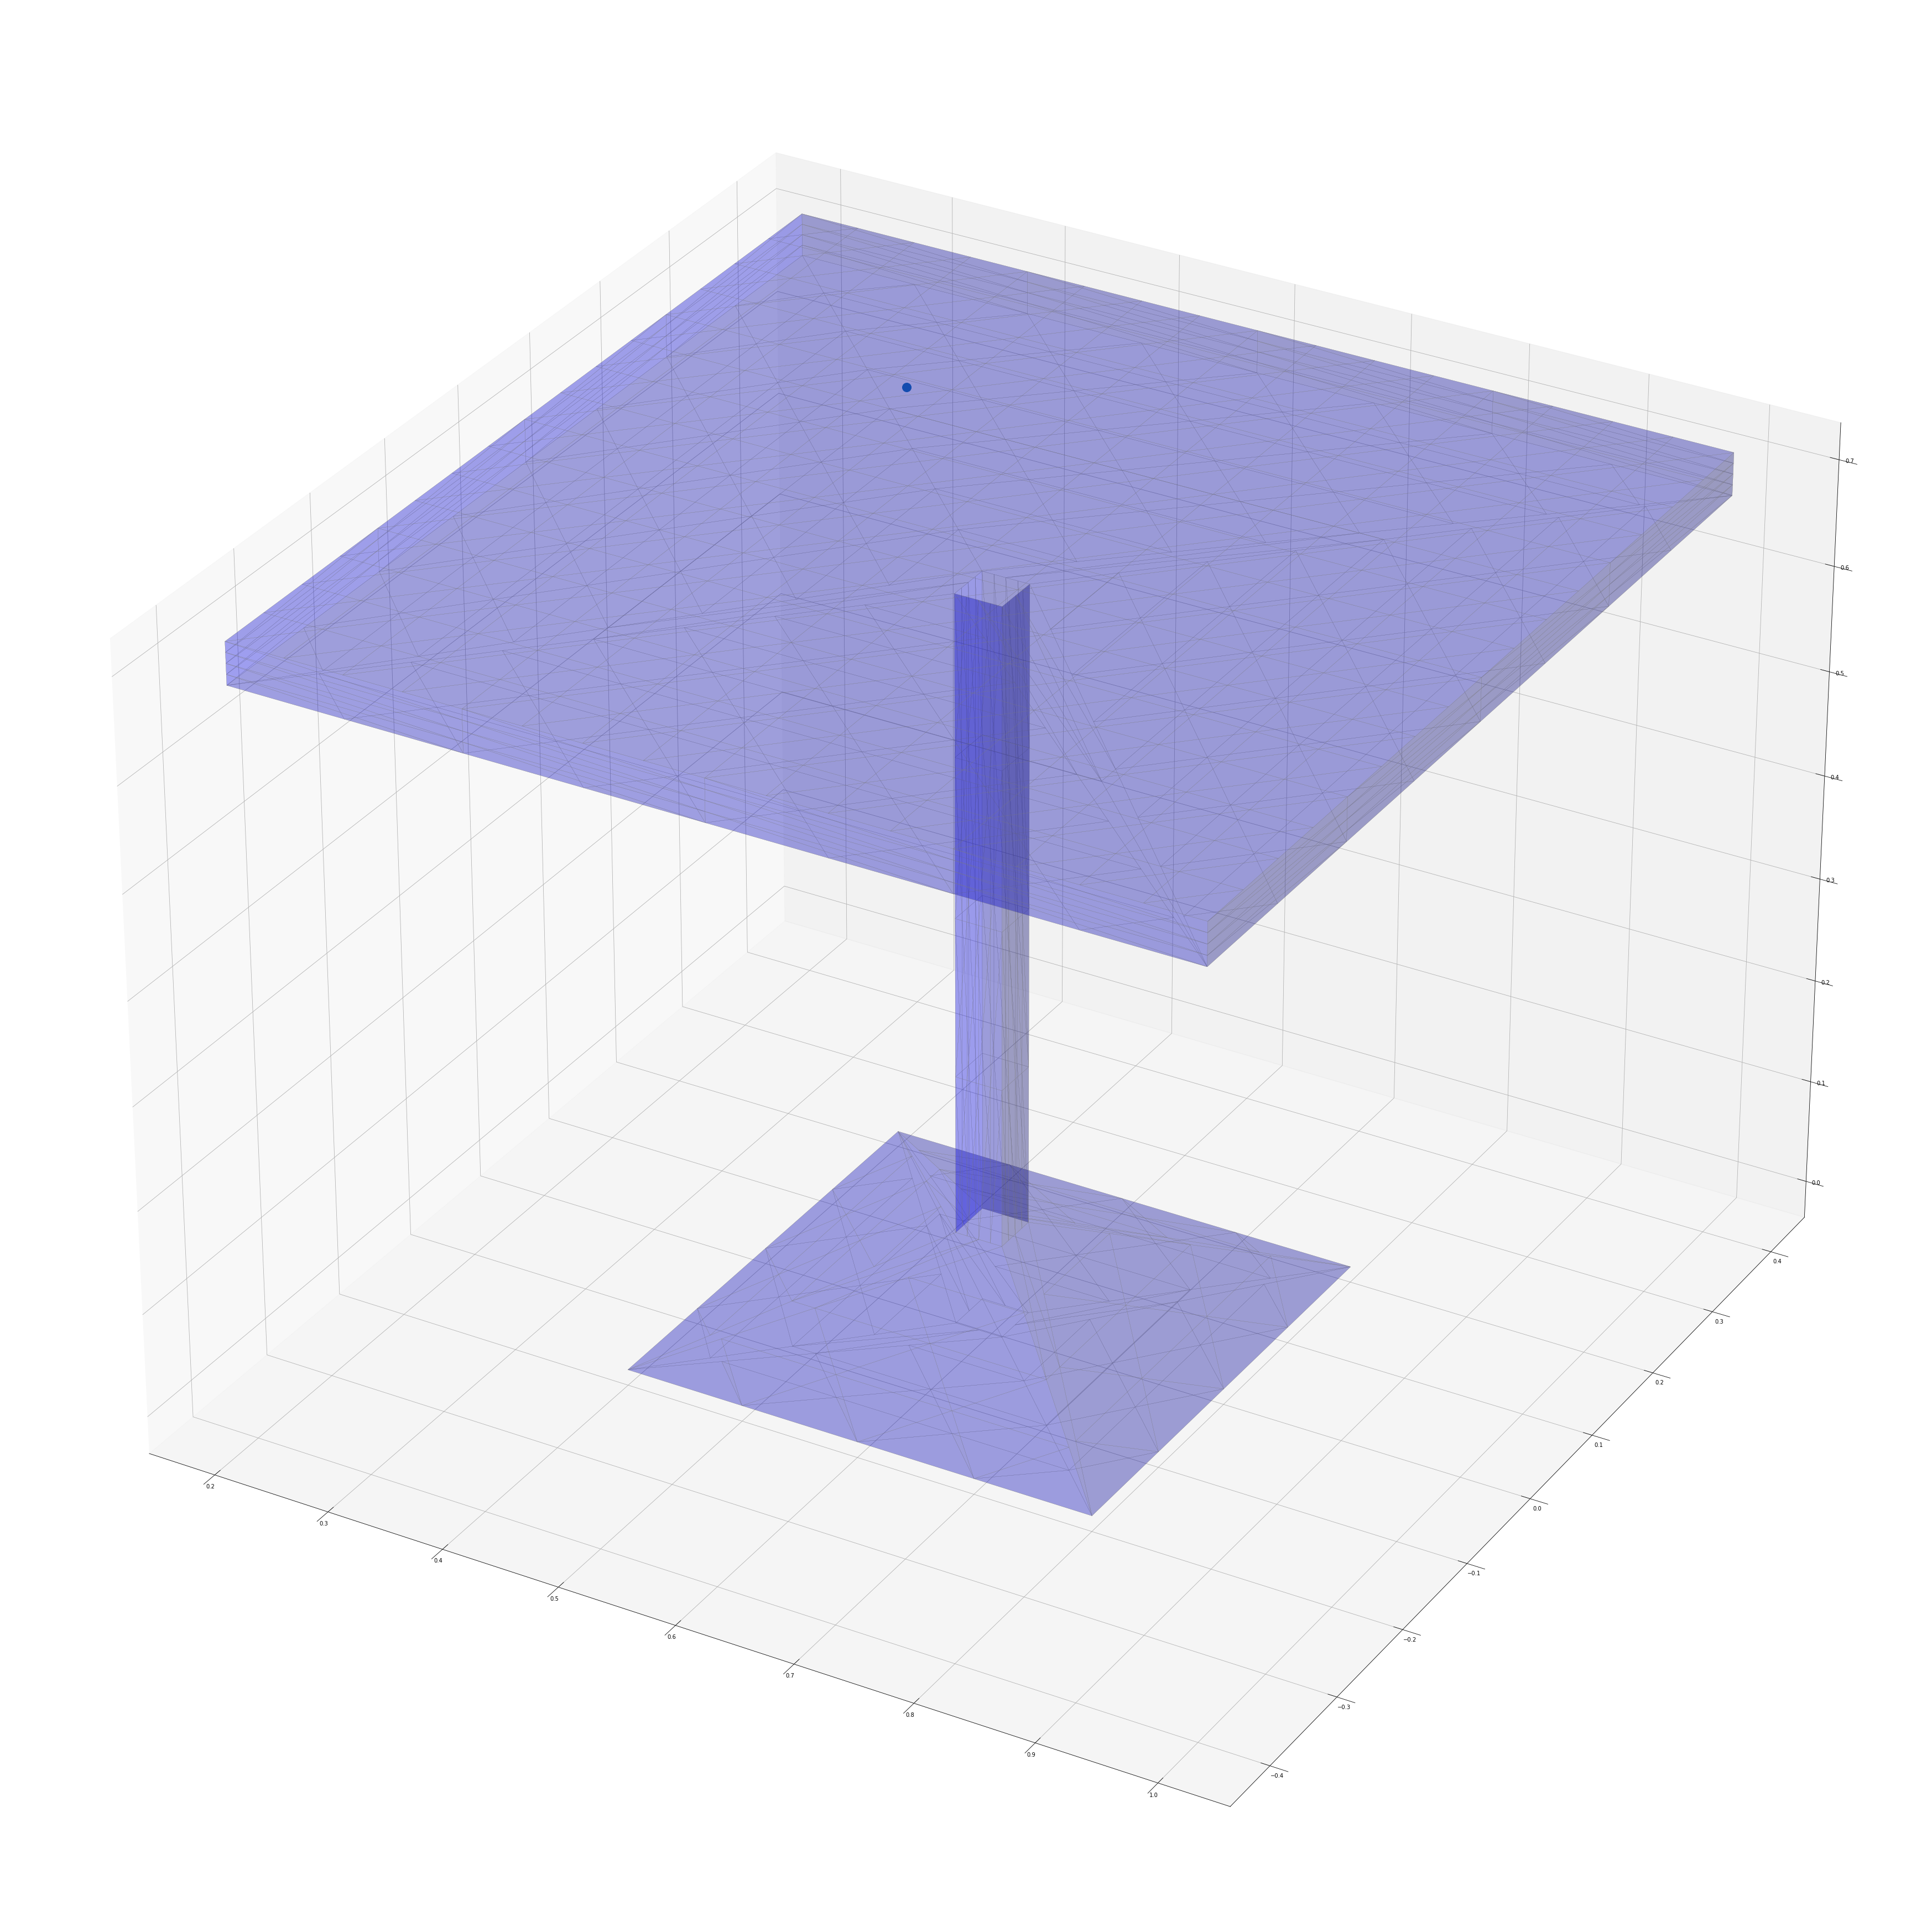

In [176]:
plt.figure(figsize=(64,64))
ax = visualize_trimesh(mesh2, T2)

pnts2_world = T2[:3,:3].dot(pnts2) + T2[:3,[3]]

ax.plot3D(pnts2_world[0,:],pnts2_world[1,:],pnts2_world[2,:], 'o', ms=16)

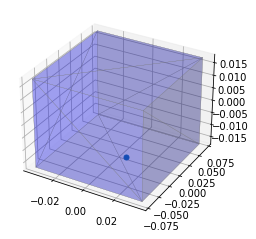

In [167]:
# plt.figure(figsize=(64,64))
ax = visualize_trimesh(mesh1)

pnts1_world = T1[:3,:3].dot(pnts1) + T1[:3,[3]]

ax.plot3D(pnts1[0,:],pnts1[1,:],pnts1[2,:], 'o', ms=5)
plt.show()